# Google Colab / Kaggle / PC

In [1]:
mode = "Colab"

In [2]:
import os

if mode == "Colab":
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/FPL_ML")
    TRAIN_PATH = "data/final_dataset.csv"
if mode == "PC":
    os.chdir("D:\PulpitE\FPL_ML")
    TRAIN_PATH = "data/final_dataset.csv"
if mode == "Kaggle":
    TRAIN_PATH = "/kaggle/input/fpl-dataset/final_dataset.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Imports

In [3]:
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
import random

# Constants and seeds

In [4]:
# FIXTURES_IN_SAMPLE
FIS = 8

# FIXTURES_FOR_PLAYER - minimal number of gameweeks required for a player
FFP = 15

FIRST_TRAIN_GW = 1
LAST_TRAIN_GW = 20

FIRST_VALID_GW = 21
LAST_VALID_GW = 21

# NEXT_GAMEWEEK = 22
# LAST_GAMEWEEK = NEXT_GAMEWEEK - 1

In [5]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_all_seeds(42)

# Device

In [6]:
device = torch.device("cuda")
# device = torch.device('mps')
# device = torch.device('cpu')

# Getting data and choosing features

In [7]:
df = pd.read_csv('data/final_dataset.csv')

In [8]:
# remembering original dataframes
df_original = df

df_gk_original = df[df["FPL position"] == "GK"]
df_def_original = df[df["FPL position"] == "DEF"]
df_mid_original = df[df["FPL position"] == "MID"]
df_fwd_original = df[df["FPL position"] == "FWD"]

In [9]:
df_original.columns

Index(['Unnamed: 0', 'Date', 'Day', 'Comp', 'Round', 'Venue', 'Squad',
       'Opponent', 'Start', 'Pos', 'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh',
       'SoT', 'CrdY', 'CrdR', 'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG',
       'xAG', 'SCA', 'GCA', 'Cmp', 'Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC',
       'Att.1', 'Succ', 'Match Report', 'Name', 'Season', 'WDL', 'GoalsTeams',
       'Team Score', 'Opp Score', 'CS', 'Was Home', 'GW', 'FPL',
       'neutral_name', 'Total Points', 'FPL position', 'Opp rating',
       'ScoreForLast5', 'ScoreAgainstLast5'],
      dtype='object')

In [10]:
# df_original[df_original["Name"] == "Erling-Haaland"]

In [11]:
# df.iloc[0]

In [12]:
df = df[df["Name"].isin(["Brenden-Aaronson", "Erling-Haaland", "Nick-Pope", "Kieran-Trippier"])]

In [13]:
info = ["Name", "GW", "FPL position"]
other = ["LSTM"]
features = ["Min", "Gls", "Ast", "Sh", "SoT", "xG", "npxG", "xAG", "SCA", "GCA", "CS", "CrdY", "CrdR", "Opp rating", "Team Score", "Opp Score", "Was Home"]
to_predict = ["Total Points"]

In [14]:
df = df[info + features + to_predict]
df[features + to_predict] = df[features + to_predict].astype("float32")

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [15]:
df.shape

(78, 21)

In [16]:
# removing NaN rows and players that appear less than 15 times
df = df.dropna()
grouped = df.groupby('Name')

# taking only players with at least FFP matches in logs
df = grouped.filter(lambda x: len(x) >= FFP)

In [17]:
df.shape

(78, 21)

In [18]:
# df.head(20)

In [19]:
last_names = df["Name"].unique()

In [20]:
df.columns

Index(['Name', 'GW', 'FPL position', 'Min', 'Gls', 'Ast', 'Sh', 'SoT', 'xG',
       'npxG', 'xAG', 'SCA', 'GCA', 'CS', 'CrdY', 'CrdR', 'Opp rating',
       'Team Score', 'Opp Score', 'Was Home', 'Total Points'],
      dtype='object')

In [21]:
df["FPL position"].unique()

array(['MID', 'FWD', 'GK', 'DEF'], dtype=object)

# DF to DataLoader

In [22]:
df_train = df[df["GW"] <= LAST_TRAIN_GW]
df_valid = df

# gk, def, mid, fwd
df_gk_train = df[(df["FPL position"] == "GK") & (df["GW"] <= LAST_TRAIN_GW)]
df_gk_valid = df[(df["FPL position"] == "GK") ]

df_def_train = df[(df["FPL position"] == "DEF") & (df["GW"] <= LAST_TRAIN_GW)]
df_def_valid = df[(df["FPL position"] == "DEF") ]

df_mid_train = df[(df["FPL position"] == "MID") & (df["GW"] <= LAST_TRAIN_GW)]
df_mid_valid = df[(df["FPL position"] == "MID") ]

df_fwd_train = df[(df["FPL position"] == "FWD") & (df["GW"] <= LAST_TRAIN_GW)]
df_fwd_valid = df[(df["FPL position"] == "FWD")]

In [23]:
# df_train

In [24]:
# df_gk.iloc[0]

In [25]:
def init_index_table(df):
    names = df["Name"].unique()
    result_dict = {}
    
    current_index = 0
    player_index = 0
    
    for name in names:
        sample_index = 0
        samples_for_names = df[df["Name"] == name].shape[0] - FIS
        for i in range(samples_for_names):
            result_dict[current_index] = [player_index, sample_index]
            current_index += 1
            sample_index += 1
        player_index += 1
    
    return result_dict

In [26]:
class PandasDataset(Dataset):
    def __init__(self, dataframe, starting_gw, ending_gw):
        self.dataframe = dataframe
        self.names = dataframe["Name"].unique()
        
        self.starting_gw = starting_gw
        self.ending_gw = ending_gw
        self.length = self.calculate_length()
        self.cut_unused_rows()

        self.index_table = init_index_table(self.dataframe)
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def cut_unused_rows(self):
        for name in self.names:
            df_name = self.dataframe[self.dataframe["Name"] == name]
            name_length = df_name.shape[0]
            # print("NAME LENGTH", name, name_length, FIS + 1)
            if name_length >= FIS + 1:
                try:
                    first_index = df_name.index.tolist()[0]
                except IndexError:
                    first_index = None

                try:
                    last_index = max(FIS, df_name.index[df_name['GW'] < self.starting_gw].tolist()[-1]) - FIS
                except:
                    last_index = None

                # print("FIRST LAST INDEX", name, first_index, last_index)
                if first_index != None and last_index != None:
                    # print("WYCIETO", name, range(first_index, last_index + 1))
                    self.dataframe = self.dataframe.drop(range(first_index, last_index + 1))
            else:
                self.dataframe = self.dataframe.drop([df_name.index.tolist()])
                

            # print("CUTTING", name, first_index, last_index, name_length)
            # print("CUT2", df_name.index[df_name['GW'] < self.starting_gw].tolist())
            # print(self.dataframe.shape)
            # print("")

    def calculate_length(self):
        length = 0
        for name in self.names:
            df_name = self.dataframe[self.dataframe["Name"] == name].reset_index()
            name_length = df_name.shape[0]
            if name_length >= FIS + 1:
                try:
                    first_index = max(FIS + 1, df_name.index[df_name['GW'] >= self.starting_gw].tolist()[0])
                    length += (name_length - first_index)
                except IndexError:
                    first_index = None
            # print(name, first_index, name_length)
                
        return length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # print("GETITEM DF", self.dataframe)
        # print(idx)
        player_id, sample_id = self.index_table[idx]
        name = self.names[player_id]
        # print(name)

        features = self.dataframe[self.dataframe["Name"] == name]
        # print(self.dataframe[self.dataframe["Name"] == name])
        # print(features[sample_id: (sample_id + 4)])
        features = features[sample_id: (sample_id + FIS)].drop(columns=info).values[:, :-1]
        # print(features)
        # print(features)
        # print(type(features))
        # print(self.dataframe[self.dataframe["Name"] == name].values[:, -1])
        # print(type(self.dataframe[self.dataframe["Name"] == name].values[:, -1]))
        # target = self.dataframe[self.dataframe["Name"] == name].values[:, -1]
        # target = target.astype(np.float32)
        # target = torch.from_numpy(target)
        # print("GETITEM", idx, player_id, sample_id, name)
        target = np.float32(self.dataframe[self.dataframe["Name"] == name].values[(sample_id + FIS), -1])
        # print(name, idx, target, sample_id)
        # print(type(target))
        return features, target

In [27]:
# df[["Name", "FPL position"]].drop_duplicates().head(20)

In [28]:
dataset_general_train = PandasDataset(df_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_general_valid = PandasDataset(df_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_gk_train = PandasDataset(df_gk_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_gk_valid = PandasDataset(df_gk_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_def_train = PandasDataset(df_def_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_def_valid = PandasDataset(df_def_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_mid_train = PandasDataset(df_mid_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_mid_valid = PandasDataset(df_mid_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_fwd_train = PandasDataset(df_fwd_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_fwd_valid = PandasDataset(df_fwd_valid, FIRST_VALID_GW, LAST_VALID_GW)

In [29]:
# dataset_fwd_valid.dataframe

In [30]:
# dataset_general_valid.dataframe

In [31]:
# dataset_fwd_valid.__getitem__(0)

In [32]:
# df

In [33]:
# df[df["Name"].isin(["Erling-Haaland"])].index.tolist()[0]

In [34]:
# dataset_general_train.__len__(), dataset_general_valid.__len__()

In [35]:
dataset_gk_train.__len__(), dataset_gk_valid.__len__()

(10, 1)

In [36]:
dataset_def_train.__len__(), dataset_def_valid.__len__()

(10, 1)

In [37]:
dataset_mid_train.__len__(), dataset_mid_valid.__len__()

(9, 1)

In [38]:
dataset_fwd_train.__len__(), dataset_fwd_valid.__len__()

(9, 1)

In [39]:
dataset_general_valid.index_table

{0: [0, 0], 1: [1, 0], 2: [2, 0], 3: [3, 0]}

In [40]:
# dataset_fwd_valid.dataframe

In [41]:
# dataset_general_train.dataframe

In [42]:
# dataset_general_train.__getitem__(10)

In [43]:
# dataset_general_train.dataframe

In [44]:
batch_size = 16

In [45]:
dataloader_general_train = DataLoader(dataset_general_train, batch_size=batch_size, shuffle=False)
dataloader_general_valid = DataLoader(dataset_general_valid, batch_size=batch_size, shuffle=False)

dataloader_gk_train = DataLoader(dataset_gk_train, batch_size=batch_size, shuffle=False)
dataloader_def_train = DataLoader(dataset_def_train, batch_size=batch_size, shuffle=False)
dataloader_mid_train = DataLoader(dataset_mid_train, batch_size=batch_size, shuffle=False)
dataloader_fwd_train = DataLoader(dataset_fwd_train, batch_size=batch_size, shuffle=False)

dataloader_gk_valid = DataLoader(dataset_gk_valid, batch_size=batch_size, shuffle=False)
dataloader_def_valid = DataLoader(dataset_def_valid, batch_size=batch_size, shuffle=False)
dataloader_mid_valid = DataLoader(dataset_mid_valid, batch_size=batch_size, shuffle=False)
dataloader_fwd_valid = DataLoader(dataset_fwd_valid, batch_size=batch_size, shuffle=False)

In [46]:
len(dataloader_general_train), len(dataloader_gk_train), len(dataloader_def_train), len(dataloader_mid_train), len(dataloader_fwd_train)

(3, 1, 1, 1, 1)

In [47]:
len(dataloader_general_valid), len(dataloader_gk_valid), len(dataloader_def_valid), len(dataloader_mid_valid), len(dataloader_fwd_valid)

(1, 1, 1, 1, 1)

# LSTM Model

In [48]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.transpose(x, 0, 1)
        # x = x.view(-1, batch_size)
        # x = torch.transpose(x, 0, 1)
        # print("FOR", x.shape)
        # print(x.shape)
        # print(x.shape)
        out, _ = self.lstm(x)
        # print(out.shape)
        out = self.fc(out[-1])
        return out

# Training loops

In [49]:
criterion = nn.MSELoss()

In [50]:
def train_net(net, num_epochs, dataloader, optimizer):
    if len(dataloader) <= 0:
        print("Dataloader has no elements")
        return []
    loss_history = []
    for epoch in range(num_epochs):
        running_loss = 0
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = torch.flatten(inputs, 1, 2)
            inputs = inputs.unsqueeze(2).to(device)
            targets = targets.to(device)
            # print("INPUTS", inputs.shape)
            # print("TARGETS", targets.shape)
            # print(targets)
            optimizer.zero_grad()
            outputs = net(inputs).flatten().to(device)
            # print("OUTPUTS", outputs.shape)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

        loss_history.append(running_loss / len(dataloader))
        if epoch % 5 == 0:
            print(f'Epoch {epoch} Loss: {running_loss / len(dataloader)}')
    
    return loss_history

In [51]:
def plot_loss_history(loss_history):
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

## Training loop - general net

In [52]:
%%time
net = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.005)
loss_history = train_net(net, 30, dataloader_general_train, optimizer)

Epoch 0 Loss: 40.473520278930664
Epoch 5 Loss: 18.501294136047363
Epoch 10 Loss: 12.60848093032837
Epoch 15 Loss: 12.369756062825521
Epoch 20 Loss: 12.442497571309408
Epoch 25 Loss: 12.370650291442871
CPU times: user 4.74 s, sys: 1.94 s, total: 6.69 s
Wall time: 10.7 s


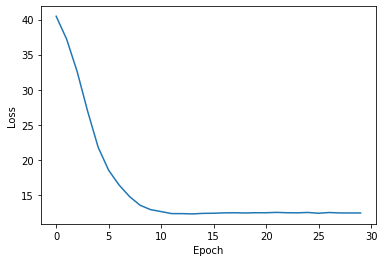

In [53]:
plot_loss_history(loss_history)

## Training loop - goalkeeper net

In [54]:
net_gk = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [55]:
%%time
optimizer_gk = optim.Adam(net_gk.parameters(), lr=0.01)
loss_history_gk = train_net(net_gk, 20, dataloader_gk_train, optimizer_gk)

Epoch 0 Loss: 31.335844039916992
Epoch 5 Loss: 23.508089065551758
Epoch 10 Loss: 13.271475791931152
Epoch 15 Loss: 7.034757137298584
CPU times: user 484 ms, sys: 3.6 ms, total: 488 ms
Wall time: 731 ms


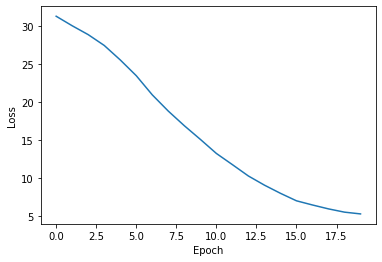

In [56]:
plot_loss_history(loss_history_gk)

## Training loop - defender net

In [57]:
net_def = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [58]:
%%time
optimizer_def = optim.Adam(net_def.parameters(), lr=0.005)
loss_history_def = train_net(net_def, 20, dataloader_def_train, optimizer_def)

Epoch 0 Loss: 74.5166015625
Epoch 5 Loss: 68.90895080566406
Epoch 10 Loss: 57.61993408203125
Epoch 15 Loss: 44.38365936279297
CPU times: user 483 ms, sys: 4.98 ms, total: 488 ms
Wall time: 780 ms


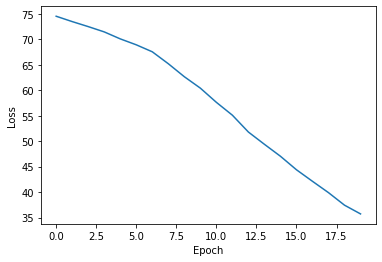

In [59]:
plot_loss_history(loss_history_def)

## Training loop - midfielder net

In [60]:
net_mid = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [61]:
%%time
optimizer_mid = optim.Adam(net_mid.parameters(), lr=0.005)
loss_history_mid = train_net(net_mid, 30, dataloader_mid_train, optimizer_mid)

Epoch 0 Loss: 5.933803081512451
Epoch 5 Loss: 3.847742795944214
Epoch 10 Loss: 1.4704443216323853
Epoch 15 Loss: 0.9177807569503784
Epoch 20 Loss: 1.1692452430725098
Epoch 25 Loss: 0.9794479012489319
CPU times: user 749 ms, sys: 8.8 ms, total: 757 ms
Wall time: 1.2 s


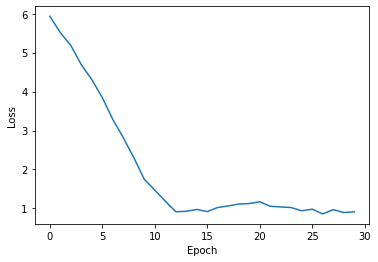

In [62]:
plot_loss_history(loss_history_mid)

## Training loop - forward net

In [63]:
net_fwd = LSTMNetwork(1, 20, 2, 1, dropout=0.5).to(device)

In [64]:
%%time
optimizer_fwd = optim.Adam(net_fwd.parameters(), lr=0.001)
loss_history_fwd = train_net(net_fwd, 30, dataloader_fwd_train, optimizer_fwd)

Epoch 0 Loss: 49.41139221191406
Epoch 5 Loss: 48.3878059387207
Epoch 10 Loss: 47.5991096496582
Epoch 15 Loss: 46.59577560424805
Epoch 20 Loss: 46.00517272949219
Epoch 25 Loss: 44.81881332397461
CPU times: user 626 ms, sys: 9.5 ms, total: 635 ms
Wall time: 1.05 s


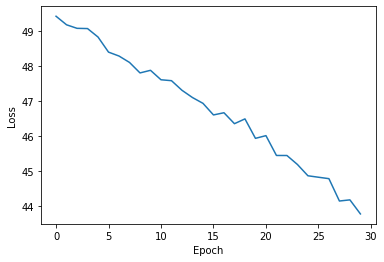

In [65]:
plot_loss_history(loss_history_fwd)

# Metrics

In [66]:
# general model


# Saving models to files

In [67]:
# general model
torch.save(net.state_dict(), 'models/lstm_general.pt')

# positional models
torch.save(net_gk.state_dict(), 'models/lstm_gk.pt')
torch.save(net_def.state_dict(), 'models/lstm_def.pt')
torch.save(net_mid.state_dict(), 'models/lstm_mid.pt')
torch.save(net_fwd.state_dict(), 'models/lstm_fwd.pt')

# Predictions - general model

In [68]:
def generate_predictions(dataloader_pos, dataset_pos, net_pos, df_original, first_gw):
    index = 0
    predictions_pos = []
    for inputs, target in dataloader_pos:
        inputs = torch.flatten(inputs, 1, 2)
        inputs = inputs.unsqueeze(2).to(device)

        # print("Inputs", inputs)
        # print("Target", target)
        # print("INPUTS", inputs)
        # print(inputs)
        outputs = net_pos(inputs).to(device)
        # print("OUTPUTS", outputs)
        for output in outputs:
            player_id, sample_id = dataset_pos.index_table[index]
            name = dataset_pos.names[player_id]
            points = round(output.item(), 2)
            # print("DFORW NEXT", player_id, sample_id, name, points)
            df_row = df_original[(df_original["Name"] == name) & (df_original["GW"] >= first_gw)].iloc[sample_id]
            # print("DFROW", df_row)
            df_row["Points"] = points
            df_gw = df_row["GW"]
            df_opp = df_row["Opponent"]

            # print("GEN PRED", player_id, sample_id, name, points, df_gw, df_opp)
            
            gw = sample_id + FIS + 1 # wrong
            predictions_pos.append(df_row)
            # df.loc[(df["Name"] == name) & (df["GW"] == gw), "LSTM"] = points
            index += 1
    
    output_df = pd.DataFrame(predictions_pos)
    output_df = output_df.loc[:, ~output_df.columns.str.contains('^Unnamed')]
    return output_df

In [69]:
prediction_columns = ["Name", "GW", "Opponent", "Was Home", "Total Points", "Points"]

In [70]:
predictions = generate_predictions(dataloader_general_valid, dataset_general_valid, net, df_original, FIRST_VALID_GW)

In [71]:
predictions.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
2904,Erling-Haaland,21,Wolves,1.0,17.0,5.65
18,Brenden-Aaronson,21,Brentford,1.0,3.0,5.64
6781,Kieran-Trippier,21,Crystal Palace,0.0,8.0,5.64
5403,Nick-Pope,21,Crystal Palace,0.0,6.0,5.60


In [72]:
# # appending results to original df
# for df_gw, df_opp, name, gw, points in predictions:
#     df_original.loc[(df_original["Name"] == name) & (df["GW"] == gw), "LSTM"] = points

In [73]:
# df_original.to_csv("data/fpl_fbref_elo_lstm.csv")

# Predictions for each position

## Goalkeepers

In [74]:
predictions_gk = generate_predictions(dataloader_gk_valid, dataset_gk_valid, net_gk, df_gk_original, FIRST_VALID_GW)

In [75]:
# results sorted
predictions_gk.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
5403,Nick-Pope,21,Crystal Palace,0.0,6.0,4.98


## Defenders

In [76]:
predictions_def = generate_predictions(dataloader_def_valid, dataset_def_valid, net_def, df_def_original, FIRST_VALID_GW)

In [77]:
# results sorted
predictions_def.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
6781,Kieran-Trippier,21,Crystal Palace,0.0,8.0,3.2


## Midfielders

In [78]:
predictions_mid = generate_predictions(dataloader_mid_valid, dataset_mid_valid, net_mid, df_mid_original, FIRST_VALID_GW)

In [79]:
# results sorted
predictions_mid.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
18,Brenden-Aaronson,21,Brentford,1.0,3.0,2.33


## Forwards

In [80]:
predictions_fwd = generate_predictions(dataloader_fwd_valid, dataset_fwd_valid, net_fwd, df_fwd_original, FIRST_VALID_GW)

In [81]:
# results sorted
predictions_fwd.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

,Name,GW,Opponent,Was Home,Total Points,Points
2904,Erling-Haaland,21,Wolves,1.0,17.0,0.65
